In [4]:
import datetime #dla czytania dat
import pandas as pd #dla czytania dat
import math 
from sympy import * #chce moc zapisac r jako zmienna 
import matplotlib.pyplot as plt #dla stworzenia wykresow
import numpy as np #by moc uzyc linspace do wykresow

In [5]:
def projekt(nazwa, kurs, nominal,prowizja, Ts, Tk, Tw, marza):
    #przygotwuje zmienne i zamieniam procenty na liczby
    r = symbols('r')
    kurs=kurs*0.01
    marza=marza*0.01
    prowizja=prowizja*0.01 
    #licze wartosc kuponu i cene czysta z naszych danych
    kupon=nominal*marza
    czysta=kurs*nominal
    #przygotowuje daty by wyliczac odsetki od ostatniego kuponu 
    liczba_dni = 0
    Tk=pd.to_datetime(Tk, format='%Y-%m-%d').date()
    Ts=pd.to_datetime(Ts, format='%Y-%m-%d').date()
    Tw=pd.to_datetime(Tw, format='%Y-%m-%d').date()
    #sprawdzam czy rok jest przestepny
    rok=Ts.year
    if (rok % 400 == 0) and (rok % 100 == 0):
        liczba_dni=366
    elif (rok % 4 ==0) and (rok % 100 != 0):
        liczba_dni=366
    else:
        liczba_dni=365
    dni=(Ts-Tk).days
    #sprawdzam ktory jest dzien tygodnia by uwzglednic ewentualna korekte
    dzien_tygodnia=Ts.weekday()+1
    if dzien_tygodnia==4 or dzien_tygodnia==5:
        odsetki=round(kupon*(max(0, dni+4))/liczba_dni,2)
    else:
        odsetki=round(kupon*(max(0, dni+2))/liczba_dni,2)
    #wyliczam cene brudna oraz koszt zakupu pojedynczej obligacji
    brudna=czysta+odsetki
    koszt=brudna*(1+prowizja)
    #zapisuje rownanie przy okazji tworzac liste t zawierajaca momenty przeplowow pieniedzy
    ilosc=math.floor((Tw-Ts).days/liczba_dni)
    t=[]
    t.append(0)
    suma=0
    for i in range(ilosc+1):
        t.append((liczba_dni-dni)/liczba_dni+(i))
        suma+=kupon*(1+r)**i
    suma=suma-koszt*(1+r)**t[-1]+nominal
    suma = Lambda(r, suma)
    #do rozwania tego rownania i znalezenia r definiuje i uzywam metody bisekcji
    def bisekcja(a,b,f):
        while abs(a - b) > 0.0000001: 
            x1 = (a + b) / 2
            if abs(f(x1)) <=0.01: 
                break
            elif f(x1) * f(a) < 0:
                b = x1 
            else:
                a = x1 
        return(a + b) / 2
    r=bisekcja(0, 1, suma)
    #tworze liste wartosci struktury terminowej dla wyzej wyznaczonych t
    B=[]
    for i in range(ilosc+2):
        B.append((1+r)**(-t[i]))
    #tworze 3 czesciowy wykres, gdzie zawre tabele z wynikami i 2 sposoby przedluzenia struktury terminow
    #najpierw przygotowuje sama tabele
    t_ap = [round(item, 3) for item in t]
    B_ap = [round(item, 3) for item in B]
    df=[["Nazwa:", "Stopa r:", "Wartości t:", "Wartości B(t):" ], 
        [nazwa, round(r,3), t_ap, B_ap]]
    fig, (ax3, ax1,ax2)  = plt.subplots(3,1, figsize=(15,15))
    table = ax3.table(cellText=df, loc='center', colWidths=[.1,.08,.41,.41])
    table.auto_set_font_size(False)
    table.set_fontsize(13)
    table.scale(1,4)
    ax3.axis('off')
    #teraz tworze petle ktora z podanych wzorow na B(t) wyliczy mi punkty w odpowiednich przedzialach i naniesie je na wykres 
    for i in range(len(t)-1):
        FX1=[]
        FX2=[]
        x=np.linspace(t[i], t[i+1], 500)
        def ciagla1(B1, B2,t1,t2):
            t=symbols('t')
            f=B1**((t2-t)/(t2-t1))*B2**((t-t1)/(t2-t1))
            f=Lambda(t, f)
            return f
        def ciagla2(B1, B2,t1,t2):
            t=symbols('t')
            f=B1+(B2-B1)*((t-t1)/(t2-t1))
            f=Lambda(t, f)
            return f
        for l in range (len(x)):
            FX1.append(ciagla1(B[i], B[i+1],t[i],t[i+1])(x[l]))
            FX2.append(ciagla2(B[i], B[i+1],t[i],t[i+1])(x[l]))
        #z wyliczonych wartosci tworze 2 wykresy i zmieniam aspekty kosmetyczne by byly czytelniejsze 
        ax1.plot(x, FX1)
        ax2.plot(x, FX2)
        ax1.scatter(t[i], B[i])
        ax1.scatter(t[-1], B[-1])
        ax2.scatter(t[i], B[i])
        ax2.scatter(t[-1], B[-1])
        ax1.set_xlim(0,t[-1])
        ax2.set_xlim(0,t[-1])
        ax1.set_xlabel("t (w latach)", size=15)
        ax2.set_xlabel("t (w latach)", size=15)
        ax1.set_xticks(t)
        ax1.set_yticks(B)
        ax2.set_xticks(t)
        ax2.set_yticks(B)
        ax1.set_title("Przedłużona struktura terminowa:", size=20)
    ax1.annotate(r'$B(t) = B(t_{i-1})^{\frac{t_i-t}{t_i-t_{i-1}}}\cdot$'
                 r'$B(t_i)^{\frac{t-t_{i-1}}{t_i-t_{i-1}}}$', 
                 [t[-1]/2, (1+B[-1])/2], size=15)
    ax2.annotate(r'$B(t) = B(t_{i-1})+(B(t_i)-B(t_{i-1}))\cdot$'
                 r'$\frac{t-t_{i-1}}{t_i-t_{i-1}}$', [t[-1]/2, 
                 (1+B[-1])/2], size=15)
    plt.savefig("projekt.jpg")

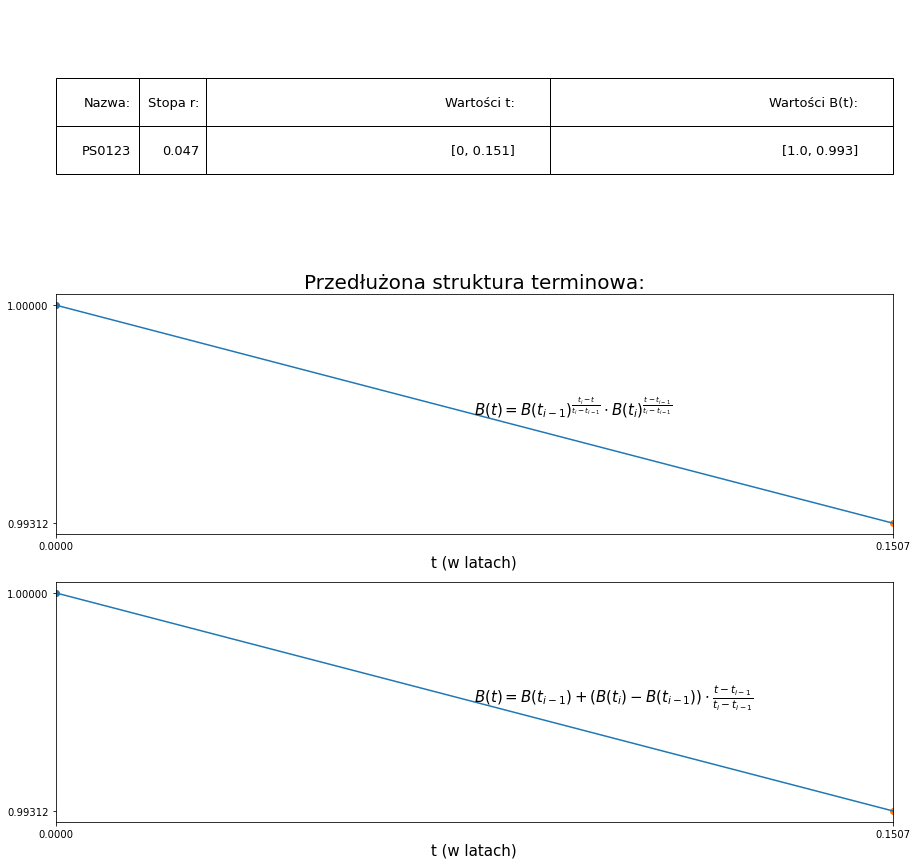

In [6]:
projekt("PS0123", 99.45, 1000, 0.19, "2022-12-01", "2022-01-25", "2023-01-25", 2.5)

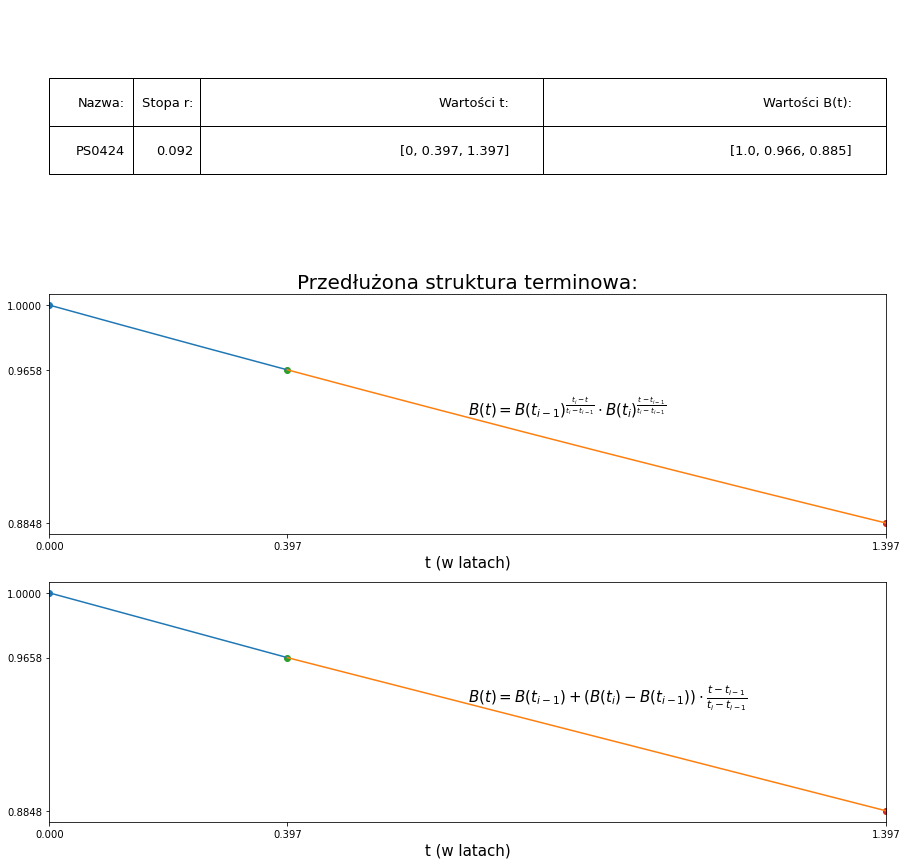

In [278]:
projekt("PS0424", 95.1, 1000,0.19, "2022-12-01", "2022-04-25", "2024-04-25", 5.5)

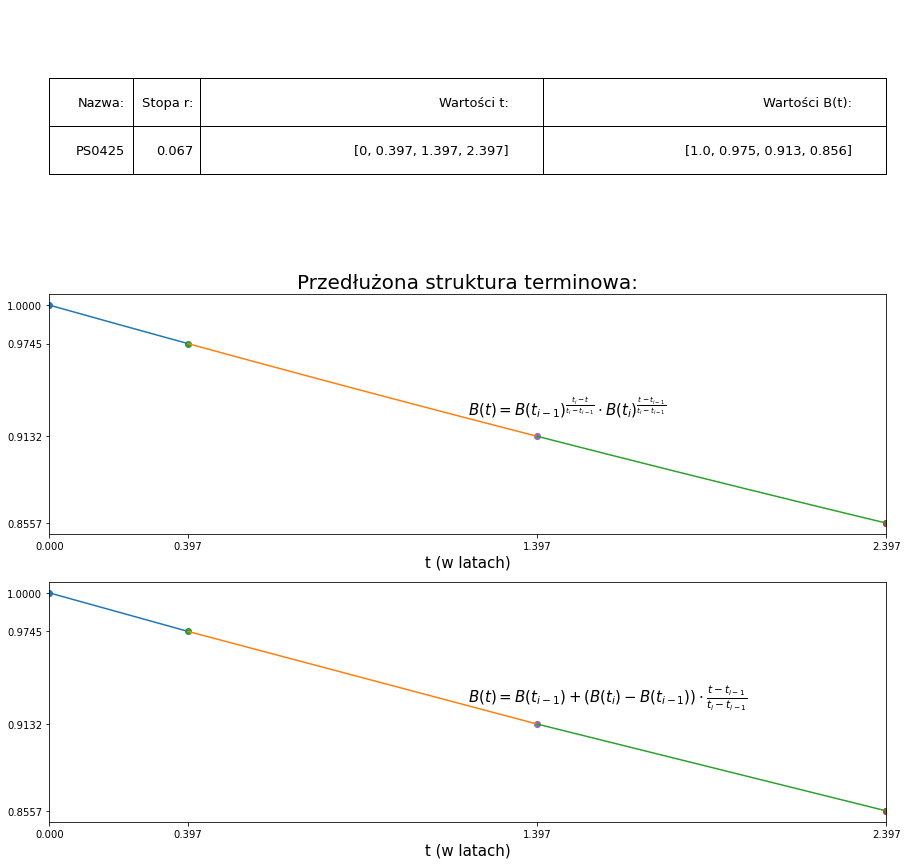

In [279]:
projekt("PS0425", 87, 1000,0.19, "2022-12-01", "2022-04-25", "2025-04-25", 0.75)

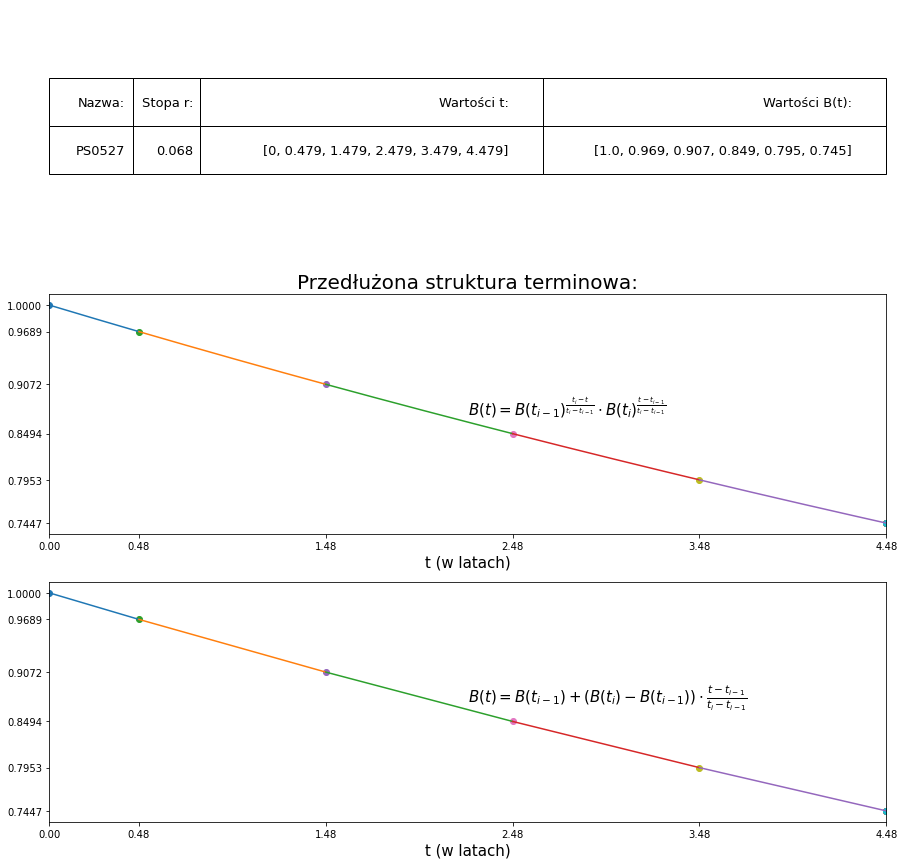

In [280]:
projekt("PS0527", 88.3, 1000,0.19, "2022-12-01", "2022-05-25", "2027-05-25", 3.75)

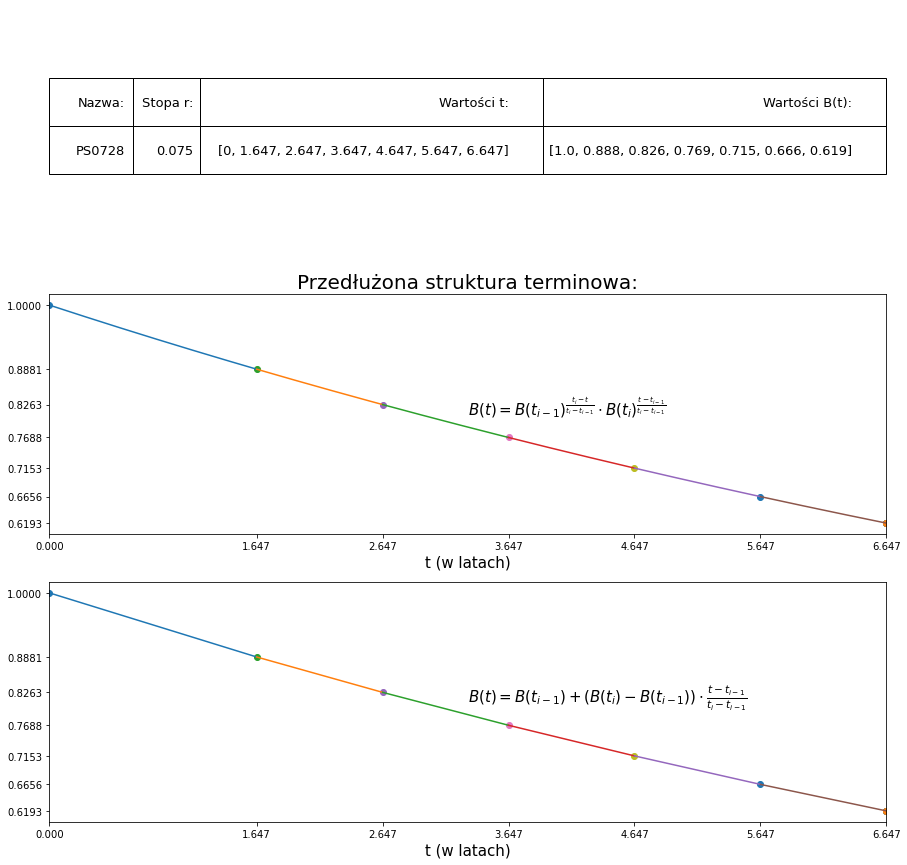

In [281]:
projekt("PS0728", 95.37, 1000,0.19, "2022-12-01", "2023-07-25", "2028-07-25", 7.5)